In [1]:
from matplotlib import pyplot as plt

#import all environments
import pandas as pd
import numpy as np
import seaborn as sns

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

## Loading data 
We add two columns, -kind- for distinguishing between experimental and simulated data and a normalization of the data. 

In [2]:
#High Temp Data
df_experimental_500K = pd.read_csv("../data/SnSe_Feb_500K.csv")
df_experimental_500K["kind"]="experimental"
df_experimental_500K["value"]=df_experimental_500K["y"]/df_experimental_500K["y"].max()
print("Contents in csv file:\n", df_experimental_500K)

Contents in csv file:
        x         y      yerr          kind     value
0    0.4  0.000517  0.000003  experimental  0.037710
1    0.8  0.001080  0.000009  experimental  0.078775
2    1.2  0.001680  0.000014  experimental  0.122538
3    1.6  0.002310  0.000020  experimental  0.168490
4    2.0  0.002940  0.000024  experimental  0.214442
..   ...       ...       ...           ...       ...
75  30.4  0.008060  0.000091  experimental  0.587892
76  30.8  0.007890  0.000094  experimental  0.575492
77  31.2  0.007770  0.000098  experimental  0.566740
78  31.6  0.007730  0.000102  experimental  0.563822
79  32.0  0.007680  0.000107  experimental  0.560175

[80 rows x 5 columns]


In [3]:
#Low Temp Data that broadening will be applied to
df_simulated_295K = pd.read_csv("../data/Calc 295K wo vdW.csv")
print("Contents in csv file:\n", df_simulated_295K)

Contents in csv file:
             x         y
0     0.00000  0.000050
1     0.05170  0.000055
2     0.10339  0.000070
3     0.15509  0.000094
4     0.20679  0.000128
..        ...       ...
577  29.82897  0.012090
578  29.88066  0.012040
579  29.93236  0.012000
580  29.98406  0.011960
581  30.03575  0.011920

[582 rows x 2 columns]


In [4]:
#Calculation of Broadening 

#Since the spacing between energies is not constant, it is better to take the mean value as characteristic size.  
dE = df_simulated_295K.x.diff().mean()

#In Order of powers;
#Boundary scattering v/L 
#Umklapp scattering Bw^2T^3
#Impurity Scattering Aw^2
#Instrument resolution - Step function

#A=v/L=Phonon velocity/Characteristic Length
A = 0.5
#B~2*kB^2*gamma^2/ShearModulus*hbar*DebeyeTemp*VolumePerAtom
B = 10**-12
#C=VolumePerAtom*ScatteringStrength/4Pi*vg^3
C = 10**-12
#D=Intensity of Step function
D = 3
#k=Sharpness of Step function
k = 0.15
#z=Position Step function begins
z = 12
#T=Temperature
T = 500

#Using lambda functions and -apply- is faster than iterating over values. This is because numpy and pandas are optimized to work on vector values, not loops. 
df_simulated_295K["blurring"]=df_simulated_295K["x"].apply(lambda x : A + B*T**3*x**2  + C*x**4 + D/(1+np.exp(-2*k*(x-z))))

#Here we create a vector with the value of the window we will use this to make a 2xN matrix to store the left and right index of the window for each index. 
window_size=np.array(3*df_simulated_295K["blurring"]/dE).astype(int)

#We reset the index to be sure it runs from 0 to N-1 
df_simulated_295K.reset_index(drop=True,inplace=True)
index=df_simulated_295K.index
#min and max of the index (scalar values
index_min=df_simulated_295K.index.min()
index_max=df_simulated_295K.index.max()

#The clip function keeps the index between the index's minimum and maximum possible value.
window_range=np.array([
    np.clip(index-window_size,index_min,index_max),
    np.clip(index+window_size,index_min,index_max)
])

#We are keeping this for reference. We only need the values of the blurring function. In the following example, we will change the way this works.  
τ=df_simulated_295K["blurring"].values

In [5]:
%%time
def gaussian(x, mu, τ):
    return np.exp((-(x-mu)**2.0)/(2*(τ/2.35)**2))

# In python, for-loops are not efficient. Therefore, we should minimize the calculations and access values in arrays. 
# The premade window matrix helps on reducing calculations. In addition, adding values to a list is faster than overwriting an array. 
# Therefore, it is better to use temporary variables, store the values on a list, and then create an array.   
data_list=list()
for i,(left,right) in enumerate(window_range.T):
    dp_blurred = 0
    for c in range(left,right):
        dp_blurred+=  gaussian(df_simulated_295K.x[c],df_simulated_295K.x[i], τ[i]) * df_simulated_295K.y[c]/τ[i]
    data_list.append(dp_blurred)
    
#If the list size matches the number of rows, we can add a new column directly to a data frame. 
df_simulated_295K["y_blurred1"]=data_list
df_simulated_295K

CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.73 s


,x,y,blurring,y_blurred1
0,0.00000,0.000050,0.579791,0.001682
1,0.05170,0.000055,0.581005,0.002195
2,0.10339,0.000070,0.582237,0.002815
3,0.15509,0.000094,0.583488,0.003554
4,0.20679,0.000128,0.584759,0.004423
...,...,...,...,...
577,29.82897,0.012090,3.597026,0.157518
578,29.88066,0.012040,3.597629,0.153070
579,29.93236,0.012000,3.598230,0.148661
580,29.98406,0.011960,3.598828,0.144293


In [6]:
%%time

#Here is a faster way to perform the calculation using mainly matrices. Notice the change in gaussian_op function using -subtract- to operate on matrices.
def gaussian_op(x, mu, τ):
    return np.exp((-np.subtract(x,mu)**2.0)/(2*(τ/2.35)**2))

# We can create a square matrix for each variable x,y. 
# Each row contains the values of x and y only at the specified window, and the rest has zeroes.
# In this way, we can operate on matrix operations instead of loops. 
shape_0=df_simulated_295K.shape[0]
y=np.zeros([shape_0,shape_0])
x=np.zeros([shape_0,shape_0])

#It is faster to operate on slices of arrays instead of accessing individual values. This loop runs almost like iterating over N values instead of NxN.  
for i,(left,right) in enumerate(window_range.T):
    y[left:right,i]=df_simulated_295K["y"].iloc[left:right]
    x[left:right,i]=df_simulated_295K["x"].iloc[left:right]
#Using the values property, we can access NumPy arrays from Pandas columns/rows. NumPy functions operate faster than iterators. 
# With np.sum we can aggregate the values by rows or columns using the -axis- argument. 

df_simulated_295K["y_blurred2"]=np.sum(gaussian_op(x,df_simulated_295K["x"].values,df_simulated_295K["blurring"].values)*np.divide(y,df_simulated_295K["blurring"].values),axis=0)
df_simulated_295K

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 37.1 ms


,x,y,blurring,y_blurred1,y_blurred2
0,0.00000,0.000050,0.579791,0.001682,0.001682
1,0.05170,0.000055,0.581005,0.002195,0.002195
2,0.10339,0.000070,0.582237,0.002815,0.002815
3,0.15509,0.000094,0.583488,0.003554,0.003554
4,0.20679,0.000128,0.584759,0.004423,0.004423
...,...,...,...,...,...
577,29.82897,0.012090,3.597026,0.157518,0.157518
578,29.88066,0.012040,3.597629,0.153070,0.153070
579,29.93236,0.012000,3.598230,0.148661,0.148661
580,29.98406,0.011960,3.598828,0.144293,0.144293


In [7]:
# Normalise to the highest peak
# Again, we can operate on several columns faster using -apply- and passing a function. Here we operate on each column by using axis=0. 
df_simulated_295K[["y","y_blurred1","y_blurred2"]]=df_simulated_295K[["y","y_blurred1","y_blurred2"]].apply(lambda x:x/x.max(),axis=0)
df_simulated_295K

,x,y,blurring,y_blurred1,y_blurred2
0,0.00000,0.000030,0.579791,0.000065,0.000065
1,0.05170,0.000033,0.581005,0.000085,0.000085
2,0.10339,0.000041,0.582237,0.000109,0.000109
3,0.15509,0.000056,0.583488,0.000137,0.000137
4,0.20679,0.000076,0.584759,0.000171,0.000171
...,...,...,...,...,...
577,29.82897,0.007150,3.597026,0.006076,0.006076
578,29.88066,0.007121,3.597629,0.005904,0.005904
579,29.93236,0.007097,3.598230,0.005734,0.005734
580,29.98406,0.007074,3.598828,0.005566,0.005566


In [8]:
# Here we concatenate the two data frames, the one with the experimental data and the simulated data. 
# First, we -melt- the simulated data. The melt function transforms the data frame from (x, y, blurring, y_blurred1, y_blurred2) to (x, kind, value) where kind is a column with y, blurring, y_blurred1, y_blurred2. 
# The goal is to have a data frame with three columns: x,value and kind (we should use better names for the columns, the interactive notebooks has better naming convention). 
# This format is convenient for plotting when using the seaborn library.
df=pd.concat([pd.melt(df_simulated_295K,id_vars="x",var_name="kind"),df_experimental_500K],ignore_index=True)
df

,x,kind,value,y,yerr
0,0.00000,y,0.000030,NaN,NaN
1,0.05170,y,0.000033,NaN,NaN
2,0.10339,y,0.000041,NaN,NaN
3,0.15509,y,0.000056,NaN,NaN
4,0.20679,y,0.000076,NaN,NaN
...,...,...,...,...,...
2403,30.40000,experimental,0.587892,0.00806,0.000091
2404,30.80000,experimental,0.575492,0.00789,0.000094
2405,31.20000,experimental,0.566740,0.00777,0.000098
2406,31.60000,experimental,0.563822,0.00773,0.000102


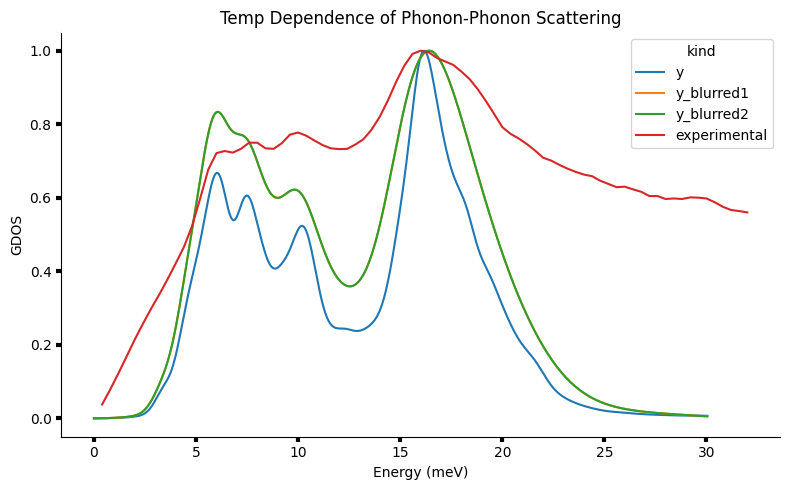

In [9]:
fig, ax = plt.subplots(figsize=(8,5))

# Here we can plot a comparison of the DOS. We filter out the blurring function using a query. 
sns.lineplot(data=df.query("kind != 'blurring'")
    , x='x'
    , y='value'
    ,hue='kind'
            )
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('GDOS')
ax.set_title('Temp Dependence of Phonon-Phonon Scattering')

plt.savefig("../figures/Figure1.pdf", pad_inches=0.2,bbox_inches="tight")

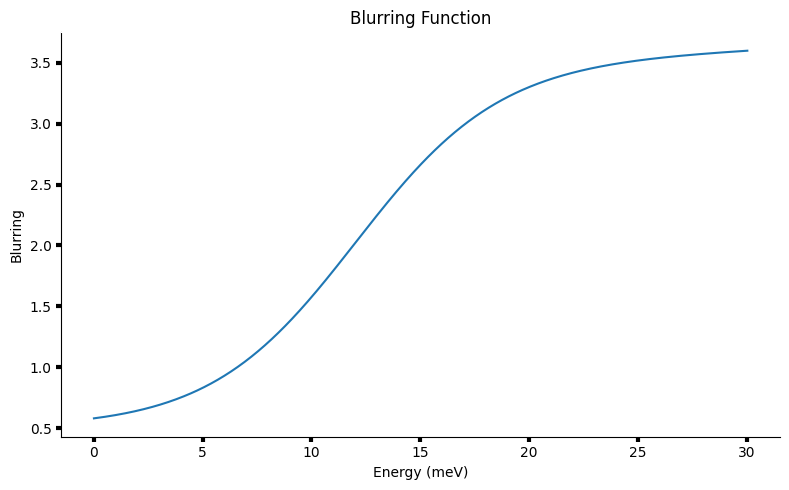

In [10]:
fig, ax = plt.subplots(figsize=(8,5))

# Here we plot only the blurring function 
sns.lineplot(data=df.query("kind == 'blurring'")
    , x='x'
    , y='value'
    )
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Blurring')
ax.set_title('Blurring Function')

plt.savefig("../figures/Figure2.pdf", pad_inches=0.2,bbox_inches="tight")